## Importing Libraries

In [ ]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime

from meteostat import Daily, Stations

from pyspark import SparkContext, SparkSession, Row

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.functions import col, when, regexp_replace, monotonically_increasing_id, udf, count, sum, hour, minute, to_timestamp, format_string, dayofmonth, month, year, dayofweek, concat, lit, rand
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

## Data Uploading

In [ ]:
try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName("TensorFlowLocalSimulation") \
    .master("local[*]") \
    .getOrCreate() # Restart Spark session

In [ ]:
path = '../../../data/'

df = spark.read.csv(path + 'df_final_with_weather.csv',header=True, inferSchema=True, sep=",")

## Data Manipulation

### Removing Unuseful Variables

In [ ]:
# Remove diverted and cancelled flights

df = df.filter(df.Flight_Diverted == 0)
df = df.filter(df.Flight_Cancelled == 0)

In [ ]:
# Remove columns of diverted and cancelled flights

df = df.drop("Flight_Diverted")
df = df.drop("Flight_Cancelled")

In [ ]:
# Drop irrelevant columns

columns_to_drop = [ "Cancellation_Reason_Code","Carrier_Delay_Minutes",
                   "Weather_Delay_Minutes", "NAS_Delay_Minutes", "Security_Delay_Minutes",
                   "Late_Aircraft_Delay_Minutes",
                   "id", "city_orig", "state_orig", "city_dest", "state_dest"] # Add back Flight_Number (to drops) if it does not improve the model

df = df.drop(*columns_to_drop)

In [ ]:
df.show(5)

+-----------+-----------------+-------------+--------------+-------------------+------------------------+---------------------+-----------------------+-------------+------------+------------+------------+----------------------+-------------------+---------------------+-------------------------+----------------------+-------------+---------------+-------------+--------------+-----------------+--------+-----------+----+----+-----+------+
|Flight_Date|Operating_Carrier|Flight_Number|Origin_Airport|Destination_Airport|Scheduled_Departure_Time|Actual_Departure_Time|Departure_Delay_Minutes|Taxi_Out_Time|Takeoff_Time|Landing_Time|Taxi_In_Time|Scheduled_Arrival_Time|Actual_Arrival_Time|Arrival_Delay_Minutes|Scheduled_Flight_Duration|Actual_Flight_Duration|Airborne_Time|Flight_Distance|latitude_dest|longitude_dest|      distance_km|latitude|  longitude|tavg|wspd| wdir|  pres|
+-----------+-----------------+-------------+--------------+-------------------+------------------------+---------------

In [ ]:
# Other columns to drop

columns_to_drop = ["Actual_Departure_time", "Actual_Arrival_time", "Takeoff_Time", 'Actual_Flight_Duration', 'Airborne_Time']

In [ ]:
df = df.drop(*columns_to_drop)

### Convert Time Attributes

In [ ]:
# Fill missing Departure_Delay_Minutes with 0

df = df.withColumn(
    "Departure_Delay_Minutes",
    when(col("Departure_Delay_Minutes").isNull(), 0).otherwise(col("Departure_Delay_Minutes"))
)

# Fill missing Arrival_Delay_Minutes with 0

df = df.withColumn(
    "Arrival_Delay_Minutes",
    when(col("Arrival_Delay_Minutes").isNull(), 0).otherwise(col("Arrival_Delay_Minutes"))
)

In [ ]:
# Convert the formatted departure time to a timestamp, assuming same date for simplicity

df = df.withColumn("Scheduled_Departure_Timestamp",
                   format_string("%02d:%02d",
                                 (col("Scheduled_Departure_Time") / 100).cast("int"),
                                 (col("Scheduled_Departure_Time") % 100).cast("int")))

# Extract hour and minute from the timestamp

df = df.withColumn("Departure_Hour",
                   hour(col("Scheduled_Departure_Timestamp")))

df = df.withColumn("Departure_Minute",
                   minute(col("Scheduled_Departure_Timestamp")))


In [ ]:
# Convert the formatted arrival time to a timestamp, assuming same date for simplicity

df = df.withColumn("Scheduled_Arrival_Timestamp",
                   format_string("%02d:%02d",
                                 (col("Scheduled_Departure_Time") / 100).cast("int"),
                                 (col("Scheduled_Departure_Time") % 100).cast("int")))

# Extract hour and minute from the timestamp

df = df.withColumn("Arrival_Hour",
                   hour(col("Scheduled_Arrival_Timestamp")))

df = df.withColumn("Arrival_Minute",
                   minute(col("Scheduled_Arrival_Timestamp")))

In [ ]:
# Add new columns by day, month, year and day of the week

df = df.withColumn("Flight_Day", dayofmonth("Flight_Date")) \
                       .withColumn("Flight_Month", month("Flight_Date")) \
                       .withColumn("Flight_DayOfWeek", dayofweek("Flight_Date"))\
                       .withColumn("Route", concat(col("Origin_Airport"), lit("-"), col("Destination_Airport")))

In [ ]:
# Extract unique origin airports

unique_airports = df.select("Origin_Airport").distinct()
unique_airports_with_id = unique_airports.withColumn("Origin_Airport_ID", monotonically_increasing_id())

df = df.join(unique_airports_with_id, on="Origin_Airport", how="left") # Join the unique IDs back to the original DataFrame

In [ ]:
# Extract unique destination airports

unique_airports_des = df.select("Destination_Airport").distinct()
unique_airports_with_id_desc = unique_airports_des.withColumn("Destination_Airport_ID", monotonically_increasing_id())

df = df.join(unique_airports_with_id_desc, on="Destination_Airport", how="left") # Join the unique IDs back to the original DataFrame

In [ ]:
df = df.withColumn("Route_ID", concat(col("Origin_Airport_ID"), col("Destination_Airport_ID"))) # Create route id by concatenating origin and destination airport id
df = df.withColumn("Route_ID", df["Route_ID"].cast(IntegerType())) # Convert Route_ID to integer

In [ ]:
# Create a unique identifier for each carrier

unique_routes = df.select("Operating_Carrier").distinct()
unique_routes_with_id = unique_routes.withColumn("Airline_ID", monotonically_increasing_id()) # Assign unique IDs using monotonically_increasing_id

df = df.join(unique_routes_with_id, on="Operating_Carrier", how="left") # Join the unique IDs back to the original DataFrame

In [ ]:
df.show(5)

+-----------------+-------------------+--------------+-----------+-------------+------------------------+-----------------------+-------------+------------+------------+----------------------+---------------------+-------------------------+---------------+-------------+--------------+-----------------+--------+-----------+----+----+-----+------+-----------------------------+--------------+----------------+---------------------------+------------+--------------+----------+------------+----------------+-------+-----------------+----------------------+--------+----------+
|Operating_Carrier|Destination_Airport|Origin_Airport|Flight_Date|Flight_Number|Scheduled_Departure_Time|Departure_Delay_Minutes|Taxi_Out_Time|Landing_Time|Taxi_In_Time|Scheduled_Arrival_Time|Arrival_Delay_Minutes|Scheduled_Flight_Duration|Flight_Distance|latitude_dest|longitude_dest|      distance_km|latitude|  longitude|tavg|wspd| wdir|  pres|Scheduled_Departure_Timestamp|Departure_Hour|Departure_Minute|Scheduled_Arriv

In [ ]:
df = df.drop("Flight_Date")

In [ ]:
# Set the legacy time parser policy to handle datetime parsing issues

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]) # Count the number of null values in each column

null_counts.show()

+-----------------+-------------------+--------------+-------------+------------------------+-----------------------+-------------+------------+------------+----------------------+---------------------+-------------------------+---------------+-------------+--------------+-----------+--------+---------+----+----+----+----+-----------------------------+--------------+----------------+---------------------------+------------+--------------+----------+------------+----------------+-----+-----------------+----------------------+--------+----------+
|Operating_Carrier|Destination_Airport|Origin_Airport|Flight_Number|Scheduled_Departure_Time|Departure_Delay_Minutes|Taxi_Out_Time|Landing_Time|Taxi_In_Time|Scheduled_Arrival_Time|Arrival_Delay_Minutes|Scheduled_Flight_Duration|Flight_Distance|latitude_dest|longitude_dest|distance_km|latitude|longitude|tavg|wspd|wdir|pres|Scheduled_Departure_Timestamp|Departure_Hour|Departure_Minute|Scheduled_Arrival_Timestamp|Arrival_Hour|Arrival_Minute|Flight_

In [ ]:
# Drop flight date after getting weather data

df_indexed = df.drop("Scheduled_Departure_Time", "Scheduled_Departure_Timestamp", "Scheduled_Arrival_Timestamp","Route","Origin_Airport", "Destination_Airport","Operating_Carrier")

### Remove Ouliers

In [ ]:
df_indexed.count() # Count rows before outlier removal

7079005

In [ ]:
# Identify numeric columns for IQR-based outlier removal

delay_columns = ["Departure_Delay_Minutes", "Arrival_Delay_Minutes"]

for column in delay_columns:
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.01)  # Compute Q1 and Q3
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_cleaned = df_indexed.filter((col(column) >= lower_bound) & (col(column) <= upper_bound)) # Filter rows within the bounds

In [ ]:
df_cleaned.show(5)

+-------------+-----------------------+-------------+------------+------------+----------------------+---------------------+-------------------------+---------------+-------------+--------------+-----------------+--------+-----------+----+----+-----+------+--------------+----------------+------------+--------------+----------+------------+----------------+-----------------+----------------------+--------+----------+
|Flight_Number|Departure_Delay_Minutes|Taxi_Out_Time|Landing_Time|Taxi_In_Time|Scheduled_Arrival_Time|Arrival_Delay_Minutes|Scheduled_Flight_Duration|Flight_Distance|latitude_dest|longitude_dest|      distance_km|latitude|  longitude|tavg|wspd| wdir|  pres|Departure_Hour|Departure_Minute|Arrival_Hour|Arrival_Minute|Flight_Day|Flight_Month|Flight_DayOfWeek|Origin_Airport_ID|Destination_Airport_ID|Route_ID|Airline_ID|
+-------------+-----------------------+-------------+------------+------------+----------------------+---------------------+-------------------------+----------

In [ ]:
df_cleaned = df_cleaned.drop("Taxi_Out")

In [ ]:
df_cleaned.count() # Count rows after outlier removal

6426407

###  Sampling

In [ ]:
processed_df = df_cleaned

processed_df.select("Departure_Delay_Minutes").describe().show() # Distributiom of delay minutes

+-------+-----------------------+
|summary|Departure_Delay_Minutes|
+-------+-----------------------+
|  count|                6426407|
|   mean|      0.548752670037861|
| stddev|     11.533541878294189|
|    min|                  -60.0|
|    max|                  237.0|
+-------+-----------------------+



In [ ]:
sampled_df = processed_df

In [ ]:
sampled_df.count()

6426407

In [ ]:
sampled_df.show(2)

+-------------+-----------------------+-------------+------------+------------+----------------------+---------------------+-------------------------+---------------+-------------+--------------+-----------------+--------+-----------+----+----+-----+------+--------------+----------------+------------+--------------+----------+------------+----------------+-----------------+----------------------+--------+----------+
|Flight_Number|Departure_Delay_Minutes|Taxi_Out_Time|Landing_Time|Taxi_In_Time|Scheduled_Arrival_Time|Arrival_Delay_Minutes|Scheduled_Flight_Duration|Flight_Distance|latitude_dest|longitude_dest|      distance_km|latitude|  longitude|tavg|wspd| wdir|  pres|Departure_Hour|Departure_Minute|Arrival_Hour|Arrival_Minute|Flight_Day|Flight_Month|Flight_DayOfWeek|Origin_Airport_ID|Destination_Airport_ID|Route_ID|Airline_ID|
+-------------+-----------------------+-------------+------------+------------+----------------------+---------------------+-------------------------+----------

## Random Forest Regressor

In [ ]:
# Create an assembler object

assembler = VectorAssembler(inputCols=["Flight_Number","Landing_Time","Flight_Distance",
                                        "latitude_dest","longitude_dest","latitude","longitude","distance_km","tavg","wspd","wdir","pres",
                                        "Departure_Hour", "Departure_Minute", "Arrival_Hour", "Arrival_Minute","Flight_Day", "Flight_Month",
                                        "Flight_DayOfWeek","Origin_Airport_ID", "Destination_Airport_ID","Route_ID","Airline_ID"
                                       ],
                            outputCol="features")

In [ ]:
train_data, test_data = sampled_df.randomSplit([0.7, 0.3]) # Split data into training and test
rf = RandomForestRegressor(featuresCol="features", labelCol="Departure_Delay_Minutes") # Create a RandomForestRegressor

pipeline = Pipeline(stages=[assembler, rf]) # Create a pipeline

model = pipeline.fit(train_data) # Train the model

predictions = model.transform(test_data) # Make predictions

In [ ]:
# Evaluation

evaluator = RegressionEvaluator(labelCol="Departure_Delay_Minutes", predictionCol="prediction")

mae = evaluator.setMetricName("mae").evaluate(predictions)
mse = evaluator.setMetricName("mse").evaluate(predictions)
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 7.437643344003686
MSE: 122.77611681403373
RMSE: 11.08043847571177
R2: 0.07728991303580901


In [ ]:
train_predictions = model.transform(train_data) # Make predictions on the training set

tevaluator = RegressionEvaluator(
    labelCol="Departure_Delay_Minutes",
    predictionCol="prediction",
    metricName="r2"
) # Initialize the evaluator with R2 as the metric

train_r2 = tevaluator.evaluate(train_predictions)

print(f"Training R² Score: {train_r2}")

Training R² Score: 0.0774597607936649


In [ ]:
results = predictions.select("Departure_Delay_Minutes", "prediction")

results.show(3, truncate=False)

+-----------------------+-------------------+
|Departure_Delay_Minutes|prediction         |
+-----------------------+-------------------+
|-8.0                   |-0.1376225934105629|
|-7.0                   |-0.1376225934105629|
|-6.0                   |-0.1376225934105629|
+-----------------------+-------------------+
only showing top 3 rows



### Visualization

In [ ]:
results_pd = predictions.orderBy(rand()).select("Departure_Delay_Minutes", "prediction").limit(50).toPandas() # Randomly select 50 rows and convert to pandas for visualization

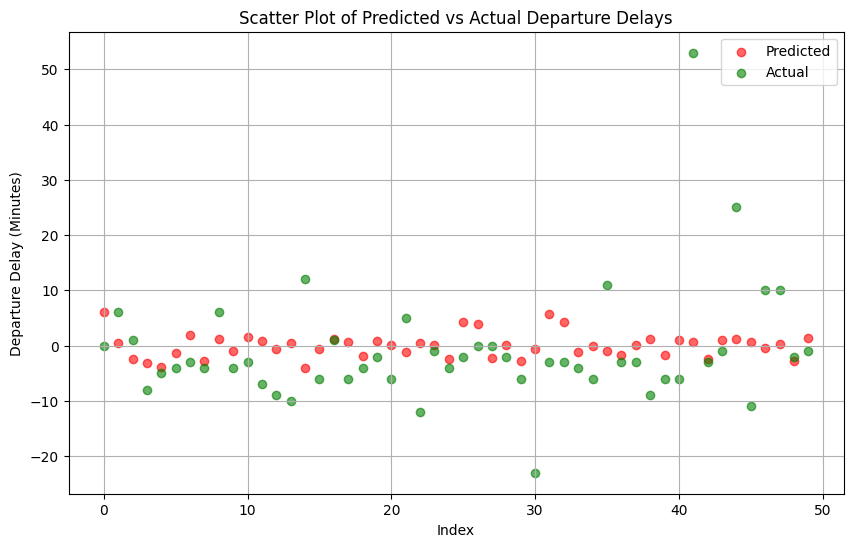

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(range(len(results_pd)), results_pd["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(results_pd)), results_pd["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)

plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Scatter Plot of Predicted vs Actual Departure Delays")
plt.legend()
plt.grid(True)

plt.show()

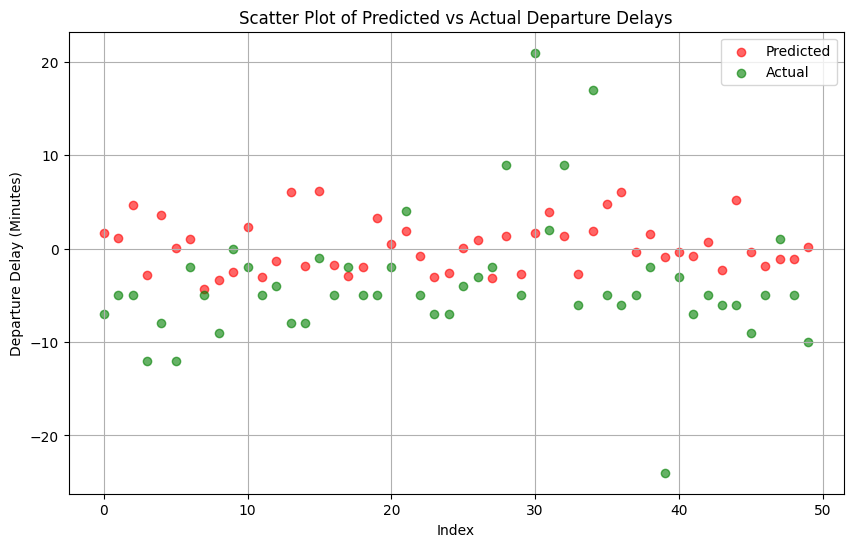

In [ ]:
results_pd = predictions.orderBy(rand()).select("Departure_Delay_Minutes", "prediction").limit(50).toPandas() # Randomly select 50 rows and convert to pandas for visualization

plt.figure(figsize=(10, 6))

plt.scatter(range(len(results_pd)), results_pd["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(results_pd)), results_pd["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)

plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Scatter Plot of Predicted vs Actual Departure Delays")
plt.legend()
plt.grid(True)

plt.show()

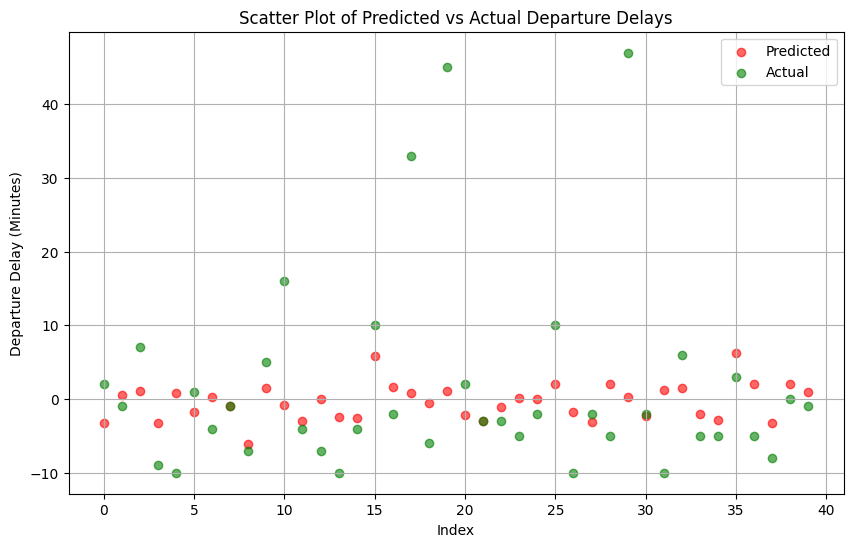

In [ ]:
results_pd = predictions.orderBy(rand()).select("Departure_Delay_Minutes", "prediction").limit(40).toPandas() # Randomly select 40 rows and convert to pandas for visualization

plt.figure(figsize=(10, 6))

plt.scatter(range(len(results_pd)), results_pd["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(results_pd)), results_pd["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)

plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Scatter Plot of Predicted vs Actual Departure Delays")
plt.legend()
plt.grid(True)

plt.show()

### Tuning

In [ ]:
evaluator = RegressionEvaluator(labelCol="Departure_Delay_Minutes", metricName="rmse")
paramGrid = ParamGridBuilder().build() # Define the grid of hyperparameters

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) # Cross-validation setup

cv_model = crossval.fit(train_data)

In [ ]:
# Evaluate the best model on the test set

cv_predictions = cv_model.transform(test_data)
cv_rmse = evaluator.evaluate(cv_predictions)
cv_mae = evaluator.setMetricName("mae").evaluate(cv_predictions)
cv_mse = evaluator.setMetricName("mse").evaluate(cv_predictions)

In [ ]:
print(f"Cross-Validation RMSE: {cv_rmse}")
print(f"Cross-Validation MAE: {cv_mae}")
print(f"Cross-Validation MSE: {cv_mse}")

Cross-Validation RMSE: 11.080438475711768
Cross-Validation MAE: 7.437643344003686
Cross-Validation MSE: 122.77611681403376


In [ ]:
SAMPLE_SIZE = 50 # Sample size to limit the data for visualization purposes

results_pd = predictions.select("Departure_Delay_Minutes", "prediction").toPandas() # Convert predictions DataFrame to pandas

results_pd['Delay_Category'] = results_pd['Departure_Delay_Minutes'].apply(
    lambda x: 'Short' if x <= 15 else ('Medium' if x <= 60 else 'High')
) # Categorize delays

short_delays = results_pd[results_pd['Delay_Category'] == 'Short'].sample(n=min(SAMPLE_SIZE, len(results_pd[results_pd['Delay_Category'] == 'Short'])))
medium_delays = results_pd[results_pd['Delay_Category'] == 'Medium'].sample(n=min(SAMPLE_SIZE, len(results_pd[results_pd['Delay_Category'] == 'Medium'])))
high_delays = results_pd[results_pd['Delay_Category'] == 'High'].sample(n=min(SAMPLE_SIZE, len(results_pd[results_pd['Delay_Category'] == 'High'])))

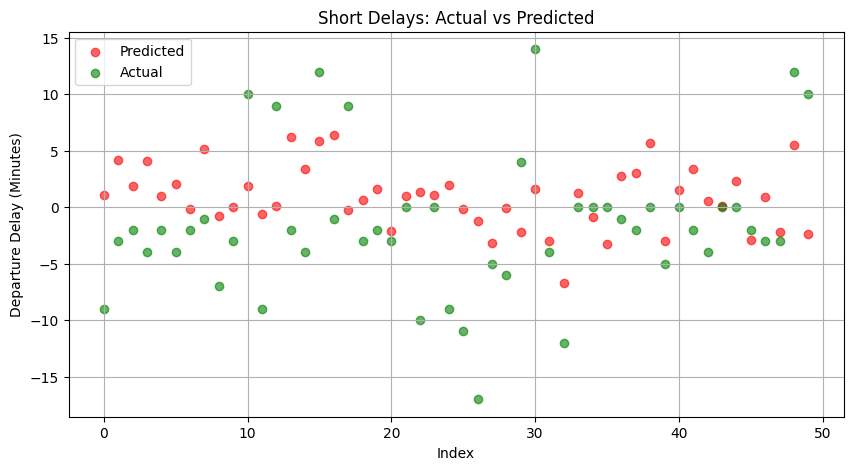

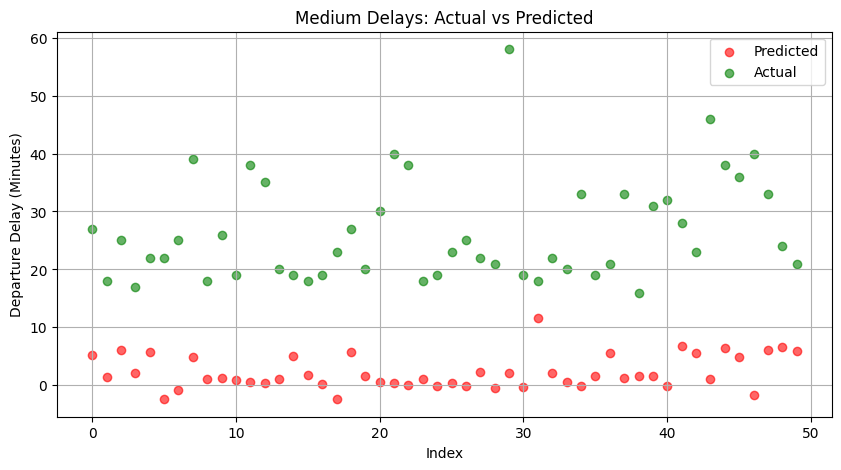

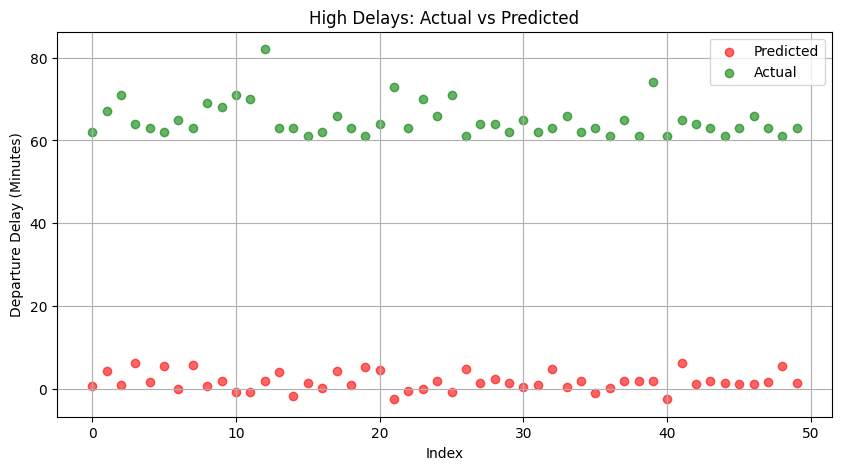

In [ ]:
# Short Delays

plt.figure(figsize=(10, 5))
plt.scatter(range(len(short_delays)), short_delays["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(short_delays)), short_delays["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)
plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Short Delays: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

# Medium Delays
plt.figure(figsize=(10, 5))
plt.scatter(range(len(medium_delays)), medium_delays["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(medium_delays)), medium_delays["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)
plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Medium Delays: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

# High Delays

plt.figure(figsize=(10, 5))
plt.scatter(range(len(high_delays)), high_delays["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(high_delays)), high_delays["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)
plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("High Delays: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Distribution of short, medium and high delays

short_count = results_pd[results_pd['Delay_Category'] == 'Short'].shape[0]
medium_count = results_pd[results_pd['Delay_Category'] == 'Medium'].shape[0]
high_count = results_pd[results_pd['Delay_Category'] == 'High'].shape[0]

print(f"Short Delays: {short_count}")
print(f"Medium Delays: {medium_count}")
print(f"High Delays: {high_count}")

Short Delays: 1731439
Medium Delays: 193436
High Delays: 1818


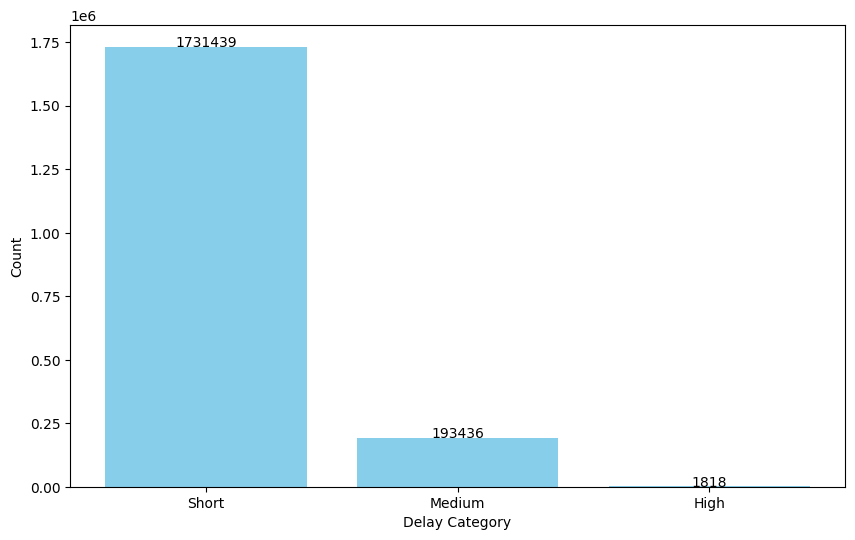

In [ ]:
categories = ['Short', 'Medium', 'High']
counts = [short_count, medium_count, high_count]

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel("Delay Category")
plt.ylabel("Count")

for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center')

### Feature Importance

In [ ]:
# Extract feature importances

feature_importances = model.stages[-1].featureImportances

fi_df = pd.DataFrame(feature_importances.toArray(), columns=["importance"])

fi_df["feature"] = ["Flight_Number","Landing_Time","Flight_Distance",
                                        "latitude_dest","longitude_dest","latitude","longitude","distance_km","tavg","wspd","wdir","pres",
                                        "Departure_Hour", "Departure_Minute", "Arrival_Hour", "Arrival_Minute","Flight_Day", "Flight_Month",
                                        "Flight_DayOfWeek","Origin_Airport_ID", "Destination_Airport_ID","Route_ID","Airline_ID"
                                       ] # Add the feature names as a new column

fi_df = fi_df.sort_values("importance", ascending=False) # Sort the DataFrame by importance

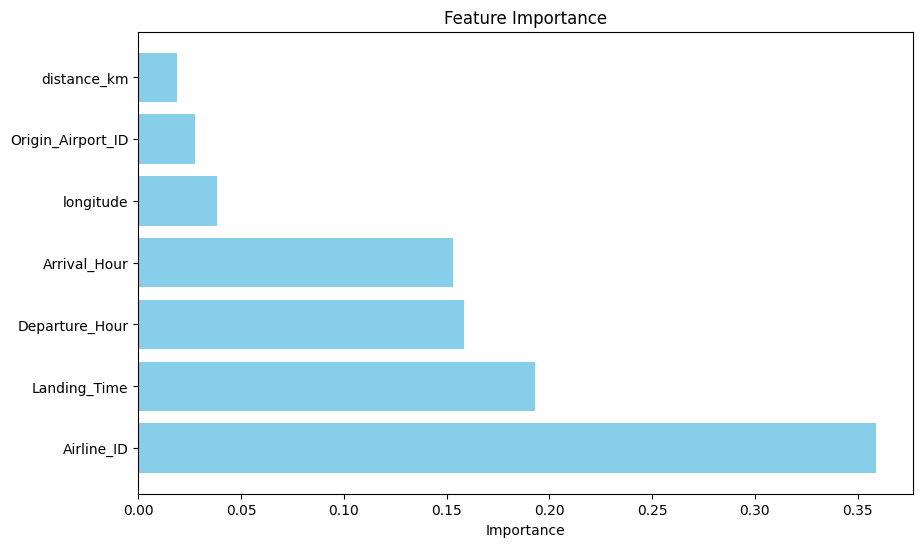

In [ ]:
plt.figure(figsize=(10, 6))

plt.barh(fi_df["feature"][:7], fi_df["importance"][:7], color='skyblue')

plt.xlabel("Importance")
plt.title("Feature Importance")

plt.show()

## GBT

In [ ]:
# Assembling

assembler = VectorAssembler(inputCols=["Flight_Number","Landing_Time","Flight_Distance",
                                        "latitude_dest","longitude_dest","latitude","longitude","distance_km","tavg","wspd","wdir","pres",
                                        "Departure_Hour", "Departure_Minute", "Arrival_Hour", "Arrival_Minute","Flight_Day", "Flight_Month",
                                        "Flight_DayOfWeek","Origin_Airport_ID", "Destination_Airport_ID","Route_ID","Airline_ID"
                                       ],
                            outputCol="features")

In [ ]:
gbt = GBTRegressor(featuresCol="features", labelCol="Departure_Delay_Minutes") # Create the GBT regressor

pipeline = Pipeline(stages=[assembler, gbt]) # Create a pipeline

model = pipeline.fit(train_data) # Train the model

predictions = model.transform(test_data) # Make predictions

In [ ]:
# Evaluation

evaluator = RegressionEvaluator(labelCol="Departure_Delay_Minutes", predictionCol="prediction")

mae = evaluator.setMetricName("mae").evaluate(predictions)
mse = evaluator.setMetricName("mse").evaluate(predictions)
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 7.201161933136384
MSE: 115.77474238802898
RMSE: 10.759867210520257
R2: 0.12990795450125858


### Feature Importance

In [ ]:
# Extract feature importances

importances = model.stages[-1].featureImportances

importances_df = pd.DataFrame(importances.toArray(), columns=["importance"])

importances_df["feature"] = ["Flight_Number", "Landing_Time", "Flight_Distance", "latitude_dest", "longitude_dest", "latitude", "longitude", "distance_km", "tavg", "wspd", "wdir",
                             "pres", "Departure_Hour", "Departure_Minute", "Arrival_Hour", "Arrival_Minute","Flight_Day", "Flight_Month", "Flight_DayOfWeek", "Origin_Airport_ID",
                             "Destination_Airport_ID", "Route_ID", "Airline_ID"] # Add the feature names as a new column

importances_df = importances_df.sort_values("importance", ascending=False) # Sort the DataFrame by importance

print(importances_df)

    importance                 feature
1     0.251970            Landing_Time
12    0.250916          Departure_Hour
22    0.104477              Airline_ID
17    0.063343            Flight_Month
6     0.060856               longitude
16    0.053500              Flight_Day
2     0.042900         Flight_Distance
5     0.039290                latitude
7     0.030946             distance_km
19    0.021293       Origin_Airport_ID
4     0.016754          longitude_dest
18    0.014838        Flight_DayOfWeek
8     0.013697                    tavg
13    0.013622        Departure_Minute
3     0.008189           latitude_dest
11    0.007563                    pres
0     0.002938           Flight_Number
10    0.001503                    wdir
9     0.001261                    wspd
20    0.000143  Destination_Airport_ID
15    0.000000          Arrival_Minute
14    0.000000            Arrival_Hour
21    0.000000                Route_ID


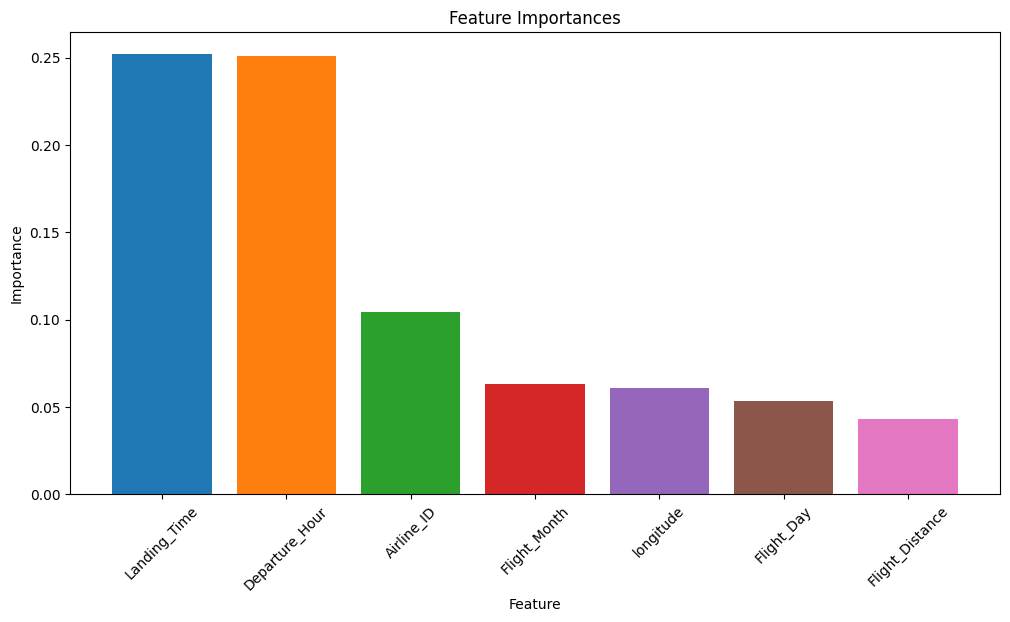

In [ ]:
# Plot the top 7 features

cmap = mpl.cm.tab10

plt.figure(figsize=(12, 6))

plt.bar(importances_df["feature"][:7], importances_df["importance"][:7], color=cmap.colors)

plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.xticks(rotation=45)
plt.show()

In [ ]:
train_predictions = model.transform(train_data) # Make predictions on the training set

tevaluator = RegressionEvaluator(
    labelCol="Departure_Delay_Minutes",
    predictionCol="prediction",
    metricName="r2"
) # Initialize the evaluator with R2 as the metric

train_r2 = tevaluator.evaluate(train_predictions)

print(f"Training R² Score: {train_r2}")

Training R² Score: 0.13045821998418716


In [ ]:
results = predictions.select("Departure_Delay_Minutes", "prediction") # Select the actual and predicted columns

results.show(5)

+-----------------------+--------------------+
|Departure_Delay_Minutes|prediction          |
+-----------------------+--------------------+
|-8.0                   |-0.6264502703175642 |
|-7.0                   |-1.0681350011415052 |
|-6.0                   |-0.8552947376698906 |
|-6.0                   |-1.2328303550614466 |
|-5.0                   |-0.30518366699050725|
+-----------------------+--------------------+
only showing top 5 rows



### Visualization

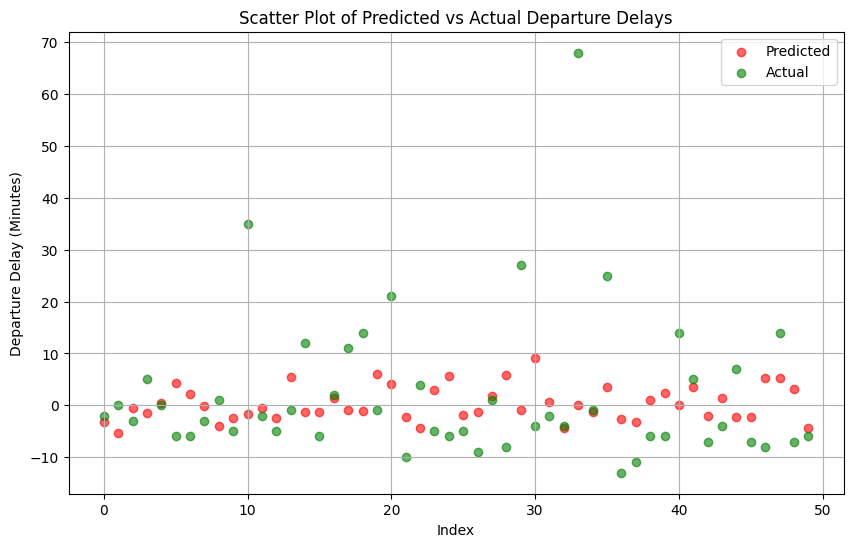

In [ ]:
results_pd = predictions.orderBy(rand()).select("Departure_Delay_Minutes", "prediction").limit(50).toPandas() # Randomly select 50 rows and convert to pandas for visualization

plt.figure(figsize=(10, 6))

plt.scatter(range(len(results_pd)), results_pd["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(results_pd)), results_pd["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)

plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Scatter Plot of Predicted vs Actual Departure Delays")
plt.legend()
plt.grid(True)
plt.show()

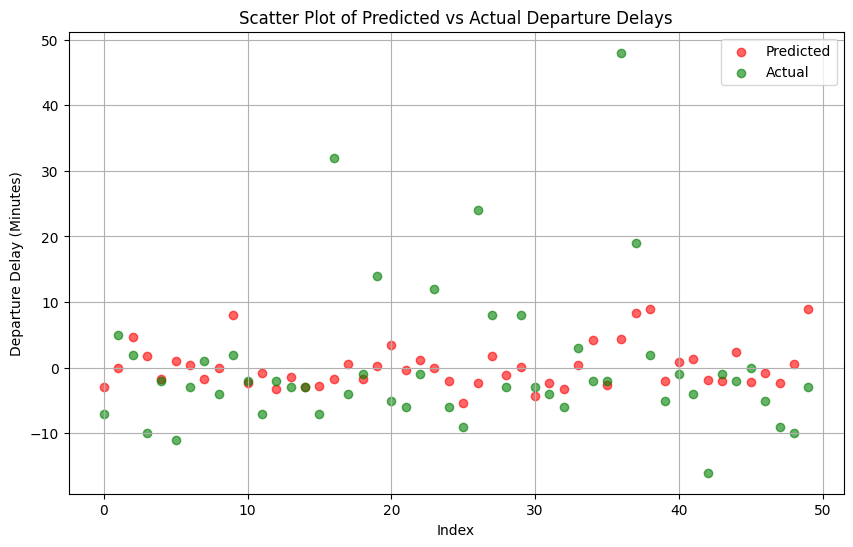

In [ ]:
results_pd = predictions.orderBy(rand()).select("Departure_Delay_Minutes", "prediction").limit(50).toPandas() # Randomly select 50 rows and convert to pandas for visualization

plt.figure(figsize=(10, 6))

plt.scatter(range(len(results_pd)), results_pd["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(results_pd)), results_pd["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)

plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Scatter Plot of Predicted vs Actual Departure Delays")
plt.legend()
plt.grid(True)
plt.show()

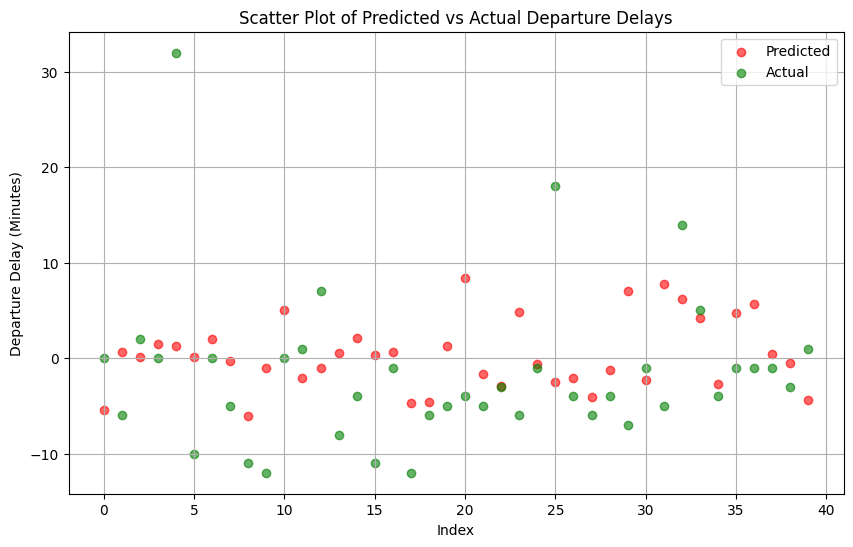

In [ ]:
results_pd = predictions.orderBy(rand()).select("Departure_Delay_Minutes", "prediction").limit(40).toPandas() # Randomly select 50 rows and convert to pandas for visualization

plt.figure(figsize=(10, 6))

plt.scatter(range(len(results_pd)), results_pd["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(results_pd)), results_pd["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)

plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Scatter Plot of Predicted vs Actual Departure Delays")
plt.legend()
plt.grid(True)
plt.show()

### Tuning

In [ ]:
evaluator = RegressionEvaluator(labelCol="Departure_Delay_Minutes", metricName="rmse") # Define the evaluator

paramGrid = ParamGridBuilder().build() # Define the grid of hyperparameters

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) # Cross-validation setup

cv_model = crossval.fit(train_data) # Perform cross-validation

In [ ]:
# Evaluate the best model on the test set

cv_predictions = cv_model.transform(test_data)

cv_rmse = evaluator.evaluate(cv_predictions)
cv_mae = evaluator.setMetricName("mae").evaluate(cv_predictions)
cv_mse = evaluator.setMetricName("mse").evaluate(cv_predictions)

print(f"Cross-Validation RMSE: {cv_rmse}")
print(f"Cross-Validation MAE: {cv_mae}")
print(f"Cross-Validation MSE: {cv_mse}")

Cross-Validation RMSE: 10.759867210520257
Cross-Validation MAE: 7.201161933136384
Cross-Validation MSE: 115.77474238802898


In [ ]:
SAMPLE_SIZE = 50

results_pd = predictions.select("Departure_Delay_Minutes", "prediction").toPandas()

results_pd['Delay_Category'] = results_pd['Departure_Delay_Minutes'].apply(
    lambda x: 'Short' if x <= 15 else ('Medium' if x <= 60 else 'High')
) # Categorize delays

short_delays = results_pd[results_pd['Delay_Category'] == 'Short'].sample(n=min(SAMPLE_SIZE, len(results_pd[results_pd['Delay_Category'] == 'Short'])))
medium_delays = results_pd[results_pd['Delay_Category'] == 'Medium'].sample(n=min(SAMPLE_SIZE, len(results_pd[results_pd['Delay_Category'] == 'Medium'])))
high_delays = results_pd[results_pd['Delay_Category'] == 'High'].sample(n=min(SAMPLE_SIZE, len(results_pd[results_pd['Delay_Category'] == 'High'])))

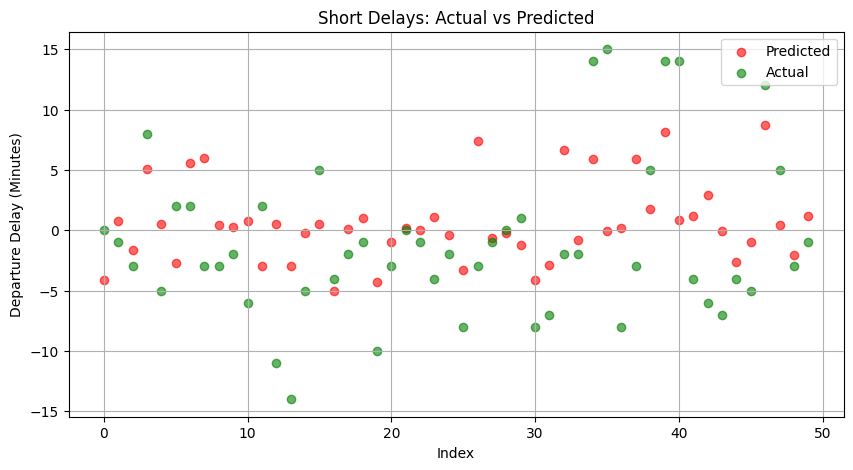

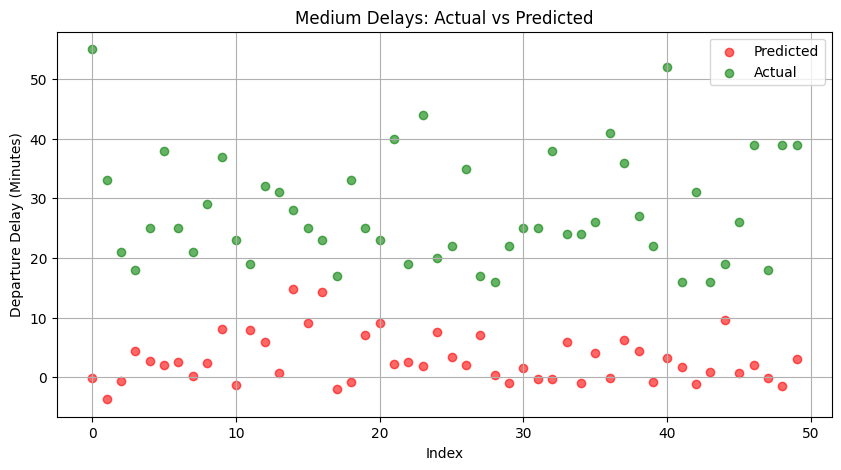

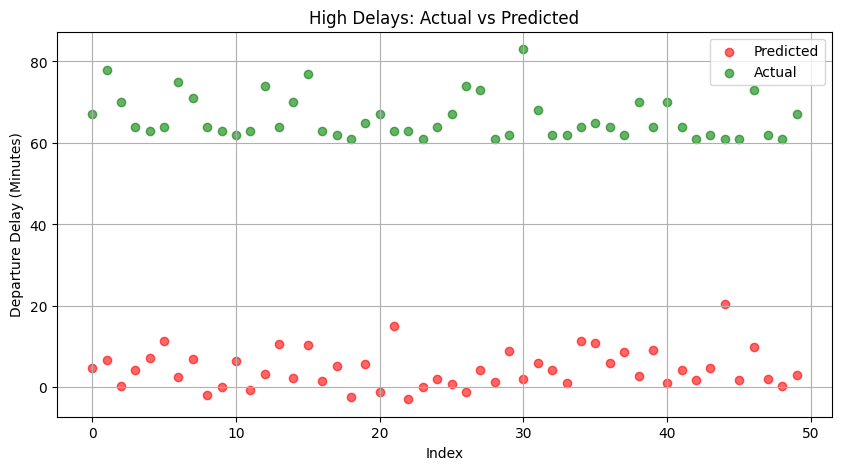

In [ ]:
# Plot Short Delays

plt.figure(figsize=(10, 5))
plt.scatter(range(len(short_delays)), short_delays["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(short_delays)), short_delays["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)
plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Short Delays: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

# Plot Medium Delays

plt.figure(figsize=(10, 5))
plt.scatter(range(len(medium_delays)), medium_delays["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(medium_delays)), medium_delays["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)
plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("Medium Delays: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

# Plot High Delays

plt.figure(figsize=(10, 5))
plt.scatter(range(len(high_delays)), high_delays["prediction"], color='red', label='Predicted', alpha=0.6)
plt.scatter(range(len(high_delays)), high_delays["Departure_Delay_Minutes"], color='green', label='Actual', alpha=0.6)
plt.xlabel("Index")
plt.ylabel("Departure Delay (Minutes)")
plt.title("High Delays: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
short_count = results_pd[results_pd['Delay_Category'] == 'Short'].shape[0]
medium_count = results_pd[results_pd['Delay_Category'] == 'Medium'].shape[0]
high_count = results_pd[results_pd['Delay_Category'] == 'High'].shape[0]

print(f"Short Delays: {short_count}")
print(f"Medium Delays: {medium_count}")
print(f"High Delays: {high_count}")

Short Delays: 1731439
Medium Delays: 193436
High Delays: 1818


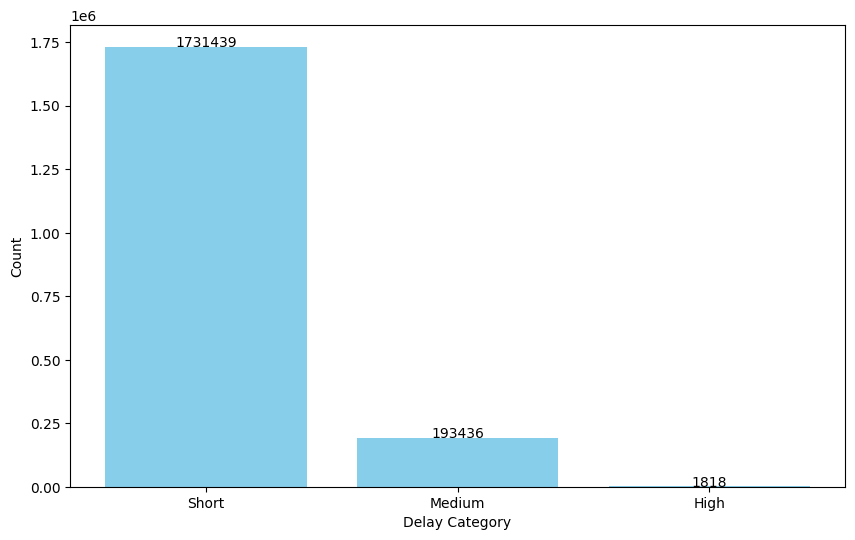

In [ ]:
categories = ['Short', 'Medium', 'High']
counts = [short_count, medium_count, high_count]

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel("Delay Category")
plt.ylabel("Count")

for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center')